In [ ]:
from tensorflow.keras.datasets.mnist import load_data

(X_train, y_train), (X_test, y_test) = load_data()
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)

11490434/11490434 [==============================] - 1s 0us/step
(60000, 28, 28)
(10000, 28, 28)
(60000,)


In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

inp = Input(shape=(28,28,1))
x = Conv2D(filters = 8, kernel_size=3, activation='relu')(inp)
x = MaxPooling2D(pool_size=(2,2))(x)

x = Flatten()(x)
x = Dense(units=32, activation='relu')(x)
x = Dense(units=2)(x)

cnn = Model(inputs=inp, outputs=x)

img1 = Input(shape=(28,28,1))
img2 = Input(shape=(28,28,1))

f1 = cnn(img1)
f2 = cnn(img2)

d = K.sqrt(K.sum(K.square(f1-f2), axis=1, keepdims=True))

model = Model(inputs=[img1, img2], outputs=d)
model.summary()
cnn.summary()

def loss(y_true, y_pred):
  proba = K.exp(-K.square(y_pred))
  return -K.mean(y_true * K.log(proba) + (1-y_true)*K.log(1-proba))

def loss1(y_true, y_pred):
  return K.mean(y_true*K.square(y_pred) + (1-y_true) * K.square(K.maximum(1.0 - y_pred,0)))

model.compile(optimizer='adam',loss=loss1)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 model (Functional)             (None, 2)            43442       ['input_2[0][0]',                
                                                                  'input_3[0][0]']                
                                                                                                  
 tf.math.subtract (TFOpLambda)  (None, 2)            0           ['model[0][0]',            

Batch size:  160
(28, 28, 1)
Pair label:  1.0


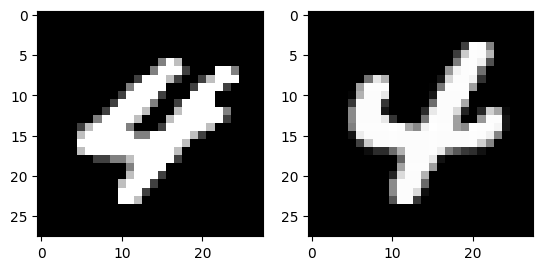

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

def generator(X,y,k=8):
  unique_labels = np.unique(y)

  while True: 
    X1 = []
    X2 = []
    y_batch =[]
    for label in unique_labels:
      label_idx = np.where(y==label)[0]
      other_labels = set(unique_labels) - {label}

      for i in range(k):
        i1 = np.random.choice(label_idx)
        i2 = np.random.choice(label_idx)

        while i1==i2:
          i2 = np.random.choice(label_idx)
        
        X1.append(X[i1][:,:,None])
        X2.append(X[i2][:,:,None])
        y_batch.append(1.0)

        i1 = np.random.choice(label_idx)
        my_label = np.random.choice(list(other_labels))
        i2 = np.random.choice(list(np.where(y == my_label)[0]))
        X1.append(X[i1][:,:,None])
        X2.append(X[i2][:,:,None])
        y_batch.append(0.0)
    yield [np.array(X1)/255, np.array(X2)/255], np.array(y_batch)

for pair, y in generator(X_test, y_test):
  print('Batch size: ', len(y))
  idx = np.random.choice(range(len(y)))
  print(pair[0][idx].shape)
  print('Pair label: ', y[idx])
  plt.subplot(121)
  plt.imshow(pair[0][idx].reshape(28,28), cmap='gray')
  plt.subplot(122)
  plt.imshow(pair[1][idx].reshape(28,28), cmap='gray')

  break


In [ ]:
history = model.fit(generator(X_train,y_train,k=32),
                    steps_per_epoch=5,
                    epochs=500,
                    validation_data=generator(X_test,y_test,k=8),
                    validation_steps=5)

Epoch 1/500
5/5 [==============================] - 7s 1s/step - loss: 0.2845 - val_loss: 0.2314
Epoch 2/500
5/5 [==============================] - 5s 1s/step - loss: 0.2226 - val_loss: 0.2110
Epoch 3/500
5/5 [==============================] - 7s 1s/step - loss: 0.2056 - val_loss: 0.1782
Epoch 4/500
5/5 [==============================] - 5s 1s/step - loss: 0.1813 - val_loss: 0.1732
Epoch 5/500
5/5 [==============================] - 3s 599ms/step - loss: 0.1701 - val_loss: 0.1516
Epoch 6/500
5/5 [==============================] - 4s 926ms/step - loss: 0.1704 - val_loss: 0.1582
Epoch 7/500
5/5 [==============================] - 3s 666ms/step - loss: 0.1528 - val_loss: 0.1508
Epoch 8/500
5/5 [==============================] - 3s 606ms/step - loss: 0.1549 - val_loss: 0.1531
Epoch 9/500
5/5 [==============================] - 3s 610ms/step - loss: 0.1462 - val_loss: 0.1426
Epoch 10/500
5/5 [==============================] - 4s 884ms/step - loss: 0.1437 - val_loss: 0.1400
Epoch 11/500
5/5 [===

Text(0, 0.5, 'Loss')

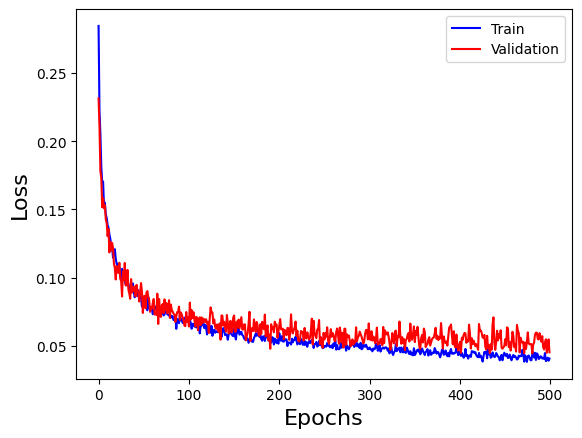

In [ ]:
plt.plot(history.history['loss'], label='Train', c='b')
plt.plot(history.history['val_loss'], label='Validation', c='r')
plt.legend()
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)

5/5 [==============================] - 0s 8ms/step
Batch size:  160
Pair label:  1.0
Distance:  [0.09755237]
Distance by feature:  [0.09755236]


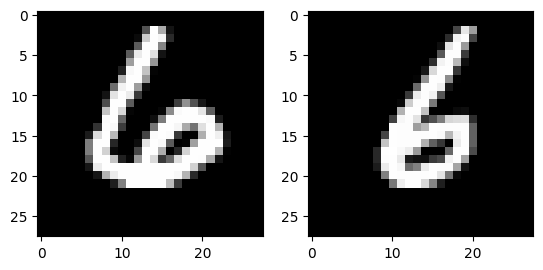

In [ ]:
for pair, y in generator(X_test,y_test):
  y_pred = model.predict(pair)
  print('Batch size: ', len(y))
  idx = np.random.choice(range(len(y)))
  print('Pair label: ', y[idx])
  print('Distance: ', y_pred[idx])

  f1 = cnn(pair[0])
  f2 = cnn(pair[1])
  d=np.sqrt(np.sum((f1-f2)**2,axis=1,keepdims=True))
  print("Distance by feature: ", d[idx])

  plt.subplot(121)
  plt.imshow(pair[0][idx].reshape(28,28), cmap='gray')
  plt.subplot(122)
  plt.imshow(pair[1][idx].reshape(28,28), cmap='gray')
  break

313/313 [==============================] - 1s 4ms/step
[7 2 1 ... 4 5 6]


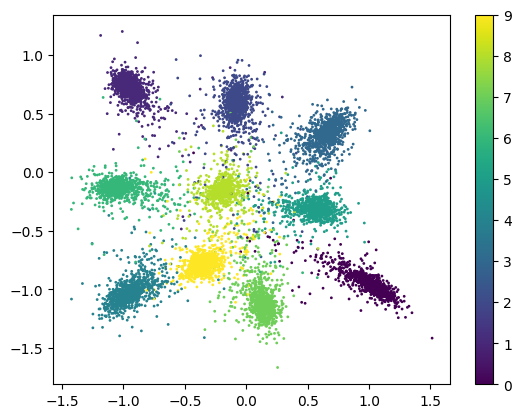

In [ ]:
f = cnn.predict(X_test/255)
p = plt.scatter(f[:,0], f[:,1],c=y_test, s=1)
plt.colorbar(p)
print(y_test)

In [ ]:
cnn.save('cnn_loss1.h5')

313/313 [==============================] - 2s 7ms/step


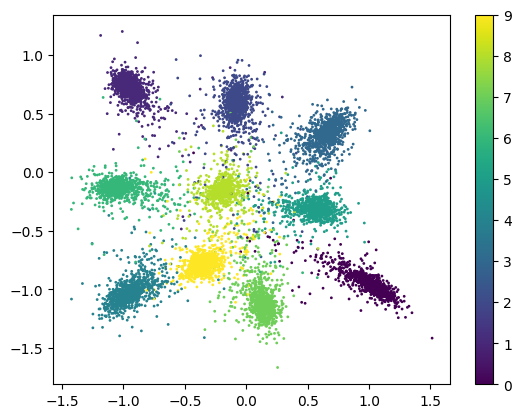

In [ ]:
from tensorflow.keras.models import load_model
m = load_model('cnn_loss1.h5')

f1 = m.predict(X_test/255)
p=plt.scatter(f1[:,0], f1[:,1], c=y_test,s=1)
plt.colorbar(p)

In [ ]:
i=0
y_true = []
y_pred = []
for pair, y in generator(X_test,y_test):
  f1=cnn(pair[0])
  f2=cnn(pair[1])
  d = np.sqrt(np.sum((f1-f2)**2, axis=1,keepdims=True))
  y_pred += list(d.ravel())
  y_true += list(y)
  i += 1
  if i>500:
    break

(array([8.40597150e-03, 3.67761253e-02, 1.38098128e-01, 4.17446549e-01,
        7.15558324e-01, 9.00189161e-01, 6.78332122e-01, 5.25223301e-01,
        5.25222924e-01, 6.22342327e-01, 5.63049782e-01, 3.64909358e-01,
        2.27561575e-01, 1.46954342e-01, 5.83915434e-02, 5.49390083e-02,
        2.70191844e-02, 5.10362372e-03, 6.00427182e-04, 1.50106580e-04]),
 array([0.02062139, 0.18683723, 0.35305306, 0.51926887, 0.68548471,
        0.85170054, 1.01791644, 1.18413222, 1.350348  , 1.51656389,
        1.68277967, 1.84899557, 2.01521134, 2.18142724, 2.34764314,
        2.5138588 , 2.68007469, 2.84629059, 3.01250648, 3.17872214,
        3.34493804]),
 <BarContainer object of 20 artists>)

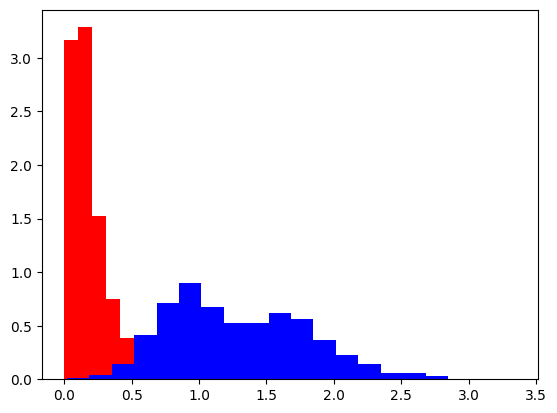

In [ ]:
y_pred = np.array(y_pred)
y_true = np.array(y_true)

positive_distances = y_pred[y_true == 1]
negative_distances = y_pred[y_true == 0]

plt.hist(positive_distances,color='r', density=True,bins=20)
plt.hist(negative_distances, color='b',density=True,bins=20)

In [ ]:
thresh = 0.5
y_pred_ = y_pred < thresh
y_pred_.astype('uint8')
from sklearn.metrics import classification_report
print(classification_report(y_true,y_pred_)) 

              precision    recall  f1-score   support

         0.0       0.94      0.97      0.96     40080
         1.0       0.97      0.94      0.95     40080

    accuracy                           0.95     80160
   macro avg       0.96      0.95      0.95     80160
weighted avg       0.96      0.95      0.95     80160

